In [1]:
import numpy as np 
import pandas as pd 
import os


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import lightgbm as lgb
import xgboost as xgb
from xgboost.sklearn import  XGBClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, log_loss, f1_score, accuracy_score, make_scorer

from keras.models import Sequential
from keras.layers import Dense, Input, Activation
from keras import optimizers, callbacks 


from keras.layers.advanced_activations import LeakyReLU
from keras.layers import BatchNormalization,Add,Dropout
from keras.models import Model, load_model

from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils, plot_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.utils import class_weight
import collections

import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression

import gc

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [2]:
train = pd.read_csv('/kaggle/input/zindi-crop-detection-final-tabular-data/train_final3.csv')
test = pd.read_csv('/kaggle/input/zindi-crop-detection-final-tabular-data/test_final3.csv')
sample_sub = pd.read_csv('/kaggle/input/zindi-crop-detection-final-tabular-data/sample_submission2.csv')
print('train shape {}'.format(train.shape))
print('test shape {}'.format(test.shape))

train shape (2494, 10363)
test shape (1074, 10362)


In [3]:
dates = ["2017-01-01", "2017-02-10", "2017-06-20", 
        "2017-07-10", "2017-07-15", "2017-08-04", "2017-08-19",
        "2017-01-31", "2017-03-12", "2017-03-22", "2017-05-31"]

features = ['red', 'green', 'blue', 'band5', 'band6', 'band7', 'nir', 'band8a', 'band11', 'band12',
           'ndvi', 'reip', 'datt3', 'gemi', 'msbi', 'ccci', 'avi', 'cvi', 'ndsi', 'siwsi', 'savi', 'evi', 'ndre',
            'cari', 'tvi', 'afair21', 'mnsi', 'afri16', 'cri550', 'cri770', 'tci', 'nbr', 'nd776', 'mcari', 'maccioni',
            'lci', 'epichla', 'gndvi2', 'gli'
           ]

columns = []
for date in dates:
    for layer in features:
        columns = columns + [
   layer+ '_val1'+date, layer+ '_val2'+date, layer+ '_val3'+date, layer+ '_val4'+date, layer+ '_val5'+date, layer+ '_val6'+date,
   layer+ '_val7'+date, layer+ '_val8'+date, layer+ '_val9'+date, layer+ '_val10'+date,
   layer+ '_val11'+date, layer+ '_val12'+date, layer+ '_val13'+date, layer+ '_val14'+date, layer+ '_val15'+date, layer+ '_val16'+date,
   layer+ '_val17'+date, layer+ '_val18'+date, layer+ '_val19'+date, layer+ '_val20'+date]

    
train_cols = columns + ['Crop_Id_Ne', 'Field_Id']
test_cols = columns + ['Field_Id']
X_train = train.drop(columns = train_cols, axis = 1)
X_train.reset_index(inplace = True, drop= True)
X_test = test.drop(columns = test_cols, axis = 1)
X_test.reset_index(inplace = True, drop= True)
y_train = train['Crop_Id_Ne']
X_train['xy'] = -(X_train['x'] + X_train['y'])/100
X_test['xy'] = -(X_test['x'] + X_test['y'])/100

print(len(X_train.columns.values))

1782


In [4]:
# source https://www.kaggle.com/super13579/lgbm-model-catboost/notebook
def kfold_catboost(train,test,train_labels,params=None,num_class=9,metrics=None, debug=False, num_folds = 5,
                   stratified = False, log = False, seed = 1):
    
    oof_valid = np.zeros((len(train),num_class))
    oof_test  = np.zeros((len(test),num_class))    
    feat_importance = pd.DataFrame()
    cv_scores = [] ## cross validation scores in each kfold and overall cv score
    train_scores=[] ## train scores of each model trained on kfold
    models = [] ## save the models
    
    if stratified:
        kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=seed)
    else:
        kf = KFold(n_splits= num_folds, shuffle=True, random_state=seed)
    
    for ind, (trn_ind, val_ind) in ( enumerate( kf.split(train,train_labels)) ):
        
        xtr, xvl = train.loc[trn_ind], train.loc[val_ind]
        ytr, yvl = train_labels[trn_ind] , train_labels[val_ind]

        
#         dtrain=lgb.Dataset(data=X_train,label=y_train, feature_name=X_train.columns)
#         dval=lgb.Dataset(data=X_valid,label=y_valid, feature_name=X_valid.columns)
#         display(X_valid.shape)
        
 
        num_round = 100000
        ## Fit the model with early stoping
        model = CatBoostClassifier( num_round, task_type='GPU', early_stopping_rounds=1000,**params,)
        model.fit(xtr, ytr, eval_set=(xvl, yvl), cat_features=[], use_best_model=True, verbose=500)
        
        ## predict on validation and test sets
        val_pred =model.predict(xvl)
        train_pred_prob = model.predict_proba(xtr)
        val_pred_prob = model.predict_proba(xvl) 
        test_pred_prob = model.predict_proba(test)
        oof_valid[val_ind,:] += np.array(val_pred_prob)
        oof_test += np.array(test_pred_prob)
        
        
        ## Print and calcualte the scores
        score_fold_validation = log_loss(yvl, val_pred_prob)
        cv_scores.append(score_fold_validation)
        score_fold_train = log_loss(ytr, train_pred_prob)
        train_scores.append(score_fold_train)
        
        if log:
            print('accuracy_score',accuracy_score(yvl,val_pred))
            print('f1 score ', f1_score(yvl, val_pred, average='weighted'))
            plot_confusion_matrix(confusion_matrix(val_pred, yvl))
    
        
        ## Calculate feature importance
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = test.columns.values
        fold_importance_df["importance"] = model.feature_importances_
#         fold_importance_df["shap_values"] = abs(shap.TreeExplainer(clf).shap_values(valid_x)[:,:test_df.shape[1]]).mean(axis=0).T
        fold_importance_df["fold"] = ind + 1
        feat_importance = pd.concat([feat_importance, fold_importance_df], axis=0)
        
        
        if not debug:
            pd.DataFrame(oof_preds).to_csv("lgb{:03}_{:.5f}_train_oof.csv".format(test_df.shape[1], score), index=False)
            sub_df = pd.read_csv('../input/sample_submission.csv')
            sub_df['TARGET'] = sub_preds
            sub_df.to_csv("lgb{:03}_{:.5f}.csv".format(test_df.shape[1], score), index= False)
        
        # Clear variables
        models.append(model)
        del model, xtr, xvl, ytr, yvl, fold_importance_df
        gc.collect()

        
        print('Iteration : {} - CV Score : {}'.format(str(ind+1),score_fold_validation))
        print('='* 80)
        
        
    oof_test /= num_folds
    
    end_train_score=np.mean(train_scores)
    oof_score=log_loss(train_labels, oof_valid)
    cv_scores.append(oof_score)
    print("ending  training  : train score {} - oof Score {}".format(str(end_train_score),str(oof_score)))

#     display_importances(feat_importance)
#     return feat_importance, models, cv_scores, oof_test, 
    return oof_test, cv_scores

In [5]:
# class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
# print(class_weights)
class_weights = [1.2, 3, 1.3, 0.9, 0.99, 1.1, 1, 0.8, 1.5]

0:	learn: 2.1752431	test: 2.1760639	best: 2.1760639 (0)	total: 24.2ms	remaining: 40m 20s
500:	learn: 0.9068397	test: 1.0044570	best: 1.0044570 (500)	total: 3.88s	remaining: 12m 51s
1000:	learn: 0.7159442	test: 0.8639501	best: 0.8639501 (1000)	total: 7.13s	remaining: 11m 45s
1500:	learn: 0.6181012	test: 0.8038538	best: 0.8038518 (1499)	total: 10.3s	remaining: 11m 18s
2000:	learn: 0.5524231	test: 0.7669875	best: 0.7669875 (2000)	total: 13.6s	remaining: 11m 5s
2500:	learn: 0.5039421	test: 0.7443145	best: 0.7442999 (2497)	total: 16.8s	remaining: 10m 55s
3000:	learn: 0.4644597	test: 0.7285248	best: 0.7285248 (2999)	total: 20.1s	remaining: 10m 48s
3500:	learn: 0.4324464	test: 0.7154818	best: 0.7154818 (3500)	total: 23.3s	remaining: 10m 42s
4000:	learn: 0.4049949	test: 0.7060520	best: 0.7059885 (3999)	total: 26.6s	remaining: 10m 37s
4500:	learn: 0.3801160	test: 0.6984347	best: 0.6984347 (4500)	total: 29.8s	remaining: 10m 32s
5000:	learn: 0.3579387	test: 0.6923818	best: 0.6922997 (4996)	total:

,field_id,crop_id_1,crop_id_2,crop_id_3,crop_id_4,crop_id_5,crop_id_6,crop_id_7,crop_id_8,crop_id_9
0,5,0.002698,0.000020,0.000890,0.002243,0.001302,0.050381,0.000999,0.838813,0.102654
1,6,0.002292,0.000035,0.001173,0.002939,0.003971,0.026647,0.001708,0.896669,0.064566
2,10,0.005153,0.000031,0.004582,0.003271,0.000768,0.003824,0.001879,0.941496,0.038996
3,18,0.000412,0.000030,0.001695,0.000700,0.000345,0.002053,0.001253,0.972461,0.021053
4,23,0.000564,0.000059,0.000750,0.000250,0.000401,0.001923,0.000424,0.917805,0.077824
5,28,0.003765,0.000145,0.759528,0.007766,0.005611,0.027965,0.150015,0.037657,0.007548
6,32,0.000447,0.000013,0.000277,0.000178,0.000447,0.004162,0.000441,0.827519,0.166516
7,35,0.001562,0.000063,0.007129,0.001214,0.000850,0.014132,0.002092,0.635647,0.337312
8,43,0.000818,0.002472,0.072190,0.014890,0.002451,0.081704,0.805782,0.015325,0.004369
9,44,0.000074,0.000550,0.003220,0.003311,0.004197,0.055654,0.931888,0.000645,0.000461


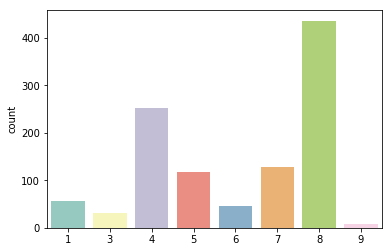

In [6]:
cat_params = {
            'learning_rate':0.01,
            'max_depth':2,
#             'eval_metric': 'Logloss',
            'objective': 'MultiClass',
            'od_type': 'Iter',
            'l2_leaf_reg': 2,
            'allow_writing_files': False,
            'class_weights': class_weights
        }
y_test, cv_scores =kfold_catboost(X_train,X_test,y_train,
                        params=cat_params,
                        num_class=9,
                        debug = True,
                        num_folds = 5
                        ,stratified = True
                                 )
print(cv_scores)
prob = pd.DataFrame(y_test)

predicted_classes = y_test.argmax(1)+1
counter=collections.Counter(predicted_classes)
print(counter)
sns.countplot(predicted_classes, palette='Set3')

# prob = pd.DataFrame(get_prediction_from_np_array(test_predict))
prob.columns = ['crop_id_1', 'crop_id_2', 'crop_id_3', 'crop_id_4', 'crop_id_5', 'crop_id_6', 'crop_id_7','crop_id_8', 'crop_id_9']
print(prob.shape)

submission = pd.DataFrame()
submission['field_id'] = sample_sub['field_id']
submission = submission.join(prob)
submission.head(30)

In [7]:
submission.to_csv('catboost.csv', index=False)